In [1]:
# imports
import numpy as np
import zipfile as zf
import time
from sklearn import linear_model
import scipy.sparse as sp
import matplotlib.pyplot as plt

In [2]:
# specify file name / location here:
file_name = 'train_triplets.txt'
zip_location = './train_triplets.txt.zip'

In [3]:
AVERAGE_LINE_SIZE = 63  # average number of bytes in a line, tells readlines() how far to read the file


def rms(vector):
    return (np.sum(vector**2)/len(vector))**0.5


class RecommenderSystem:
    def __init__(self, alpha=0.5, bins=10, codec='utf-8', file_name='train_triplets.txt', num_factors_k=30,
                 n_triplets=300000, optimization_steps=20, zip_location='./train_triplets.txt.zip'):
        """
        Initialization of a recommender system
        :param alpha:               alpha penalty of the ridge regression model (default is 0.5)
        :param bins:                how many logarithmic bins to split the play counts into (default is 10)
        :param codec:               character encoding of the .txt file
        :param file_name:           name of the .txt file
        :param num_factors_k:       how many latent factors to compute (default is 30)
        :param n_triplets:          how many triplets from the .txt file to consider (default is 300000)
        :param optimization_steps:  how many times to alternatingly optimize P and Q
        :param zip_location:        the location of the .zip file
        """
        # initialization values
        self.alpha = alpha
        self.bins = bins
        self.codec = codec
        self.file_name = file_name
        self.num_factors_k = num_factors_k
        self.n_triplets = n_triplets
        self.optimization_steps = optimization_steps
        self.zip_location = zip_location

        # create self.matrix_R_df
        self.R = self.get_matrix()
        self.n = self.R.shape[0]
        self.d = self.R.shape[1]
        # set aside 200 values from the matrix to validate
        self.test_data = self.extract_test_data()
        self.validation = self.extract_validation_data()
        # initialize P and Q using SVD
        self.P, self.Q = self.initialize_P_Q(method='random')  # svd or random

    def get_matrix(self):
        # unzip the file as far as necessary
        zfile = zf.ZipFile(self.zip_location)
        ifile = zfile.open(self.file_name)
        line_list = ifile.readlines(self.n_triplets * AVERAGE_LINE_SIZE)
        # write each entry of the triplets to their own list
        self.n_triplets = min(self.n_triplets, len(line_list))
        users = []
        songs = []
        counts = []
        for l in range(self.n_triplets):
            user, song, count = line_list[l].decode(self.codec).strip('\n').split('\t')
            users.append(user)
            songs.append(song)
            counts.append(count)
        # convert the IDs from ugly 40 byte strings to consecutive integers
        userlist, userids = np.unique(np.asarray(users), return_inverse=True)  # np.unique is getting to be my favorite
        songlist, songids = np.unique(np.asarray(songs), return_inverse=True)  # function after 2 projects in this class
        # bin the play counts
        binned_counts = np.minimum(np.asarray(np.log2(np.asarray(counts, dtype='uint64') * 2), dtype='uint64'), self.bins)
        # create the matrix
        R = sp.coo_matrix((binned_counts, (songids, userids))).tocsr()
        # recursively remove rows/columns with <=5 entries
        for i in range(10):  # just to make sure this doesn't run forever, 10 should be more than enough
            r_entries = R.tocsc()
            r_entries.data = np.ones(r_entries.data.shape)
            entries_per_row = np.asarray(r_entries.sum(1)).flatten()
            R = R[entries_per_row > 5]
            r_entries = R.tocsc()
            r_entries.data = np.ones(r_entries.data.shape)
            entries_per_column = np.asarray(r_entries.sum(0)).flatten()
            if np.min(entries_per_column) > 5 and np.min(entries_per_row) > 5:
                break
            R = R[:, entries_per_column > 5]
        return R

    def extract_test_data(self, size=200):
        test_data = np.zeros([size, 3], dtype='uint32')
        index = np.vstack(np.nonzero(self.R)).T
        shuff = np.random.permutation(index)
        for i, (x, y) in enumerate(shuff[:size]):
            test_data[i] = [x, y, self.R[x, y]]
            self.R[x, y] = 0
        return test_data

    def extract_validation_data(self, size=1000):
        validation = np.zeros([size, 3], dtype='uint32')
        index = np.vstack(np.nonzero(self.R)).T
        shuff = np.random.permutation(index)
        for i, (x, y) in enumerate(shuff[:size]):
            validation[i] = [x, y, self.R[x, y]]
            self.R[x, y] = 0
        return validation

    def initialize_P_Q(self, method='svd', num_factors_k=None):
        print('Initialize P and Q with {} method'.format(method))
        if num_factors_k:
            self.num_factors_k = num_factors_k
        if method == 'svd':
            U, S, Pt = sp.linalg.svds(self.R.asfptype(), k=self.num_factors_k)  # requires casting to float
            Q = U.dot(np.diag(S))
            P = Pt.T
        elif method == 'random':
            Q = np.random.rand(self.n, self.num_factors_k)
            P = np.random.rand(self.d, self.num_factors_k)
        return P, Q

    def iterate_minibatch(self, batchsize=25):
        rows, cols = self.R.nonzero()
        data = np.asarray(list(zip(rows, cols)))
        np.random.shuffle(data)
        counter = 0
        while counter + batchsize <= len(data):
            yield data[counter:counter+batchsize]
            counter += batchsize

    def batch_SGD(self, learning_rate=6e-4, max_epochs=500, reg=0.5, batch_size=None):
        data_size = len(self.R.nonzero()[0])
        t0 = time.time()
        regularization = [reg, reg]
        if batch_size is None or batch_size > data_size:
            batch_size = data_size
        print('Running SGD with batch size {}'.format(batch_size))
        training_errors = []
        validation_errors = []

        for epoch in range(max_epochs):
            error_arr = np.zeros(data_size)

            if batch_size > 1:
                for b, batch in enumerate(self.iterate_minibatch(batchsize=batch_size)):
                    dp = np.zeros_like(self.P)
                    dq = np.zeros_like(self.Q)
                    for e, (r, c) in enumerate(batch):
                        # calculate error for gradient
                        error = self.R[r, c] - np.dot(self.Q[r, :], self.P[c, :])  # calculate error for gradient
                        error_arr[b * batch_size + e] = error
                        dp[c, :] += learning_rate * (error * self.Q[r, :] - regularization[1] * self.P[c, :])
                        dq[r, :] += learning_rate * (error * self.P[c, :] - regularization[0] * self.Q[r, :])
                    self.P += dp
                    self.Q += dq

            else:   # for a batch size of 1 (SGD) there is no need to have a gradient matrix, a vector suffices.
                for b, ((r, c), ) in enumerate(self.iterate_minibatch(batchsize=batch_size)):
                    # calculate error for gradient
                    error = self.R[r, c] - np.dot(self.Q[r, :], self.P[c, :])  # calculate error for gradient
                    error_arr[b] = error
                    dp = learning_rate * (error * self.Q[r, :] - regularization[1] * self.P[c, :])
                    dq = learning_rate * (error * self.P[c, :] - regularization[0] * self.Q[r, :])
                    self.P[c, :] += dp
                    self.Q[r, :] += dq

#             print('Epoch {}, rms error: {:f} (validation: {:f})'.format(epoch+1, rms(error_arr), self.evaluate_val()))
            training_errors.append(rms(error_arr))
            validation_errors.append(self.evaluate_val())

            if len(validation_errors) > 2:
                if validation_errors[-1] > validation_errors[-2] > validation_errors[-3]:
                    print('Converged!')
                    break
        else:
            print('Reached epoch limit before converging!')
        return validation_errors[-3], time.time()-t0, epoch+1, training_errors, validation_errors

    def find_latent_factors_alternating(self, optimization_steps=None):
        # n: how many items/songs we have
        # d: how many users we have
        # Given:                Matrix R (n x d)
        # Find latent factors:  Matrix Q (n x k) and P (d x k) to minimize error for R = Q * P.T (=> P.T is k x d!)
        # Using alternating optimization
        # truncated svd for the initial values
        if not optimization_steps:
            optimization_steps = self.optimization_steps
        self.reg = linear_model.Ridge(alpha=self.alpha, fit_intercept=False)
        error = np.sum(np.square(self.R[self.R.nonzero()] - self.Q.dot(self.P.transpose())[self.R.nonzero()]))
        print('initial error =', error)
        for i in range(optimization_steps):  # alternatingly optimize for 20 steps (no idea how much is good)
            self.compute_P()
            self.compute_Q()
            error = np.sum(np.square(self.R[self.R.nonzero()] - self.Q.dot(self.P.transpose())[self.R.nonzero()]))
            print('error after {} steps = {}'.format(i + 1, error))

    def compute_P(self):
        for d in range(self.d):  # looping over users d to compute rows of P
            y_nonsparse = self.R.getcol(d)  # get the d'th column of items from R
            indices = y_nonsparse.nonzero()[0]
            # only select the songs in that column that user d has listened to:
            y = np.asarray(y_nonsparse[y_nonsparse.nonzero()]).flatten()
            X = self.Q[indices]  # only select the corresponding rows from Q
            self.reg.fit(X, y)  # perform ridge regression for this selection
            self.P[d] = self.reg.coef_  # write this result to the d'th row of P

    def compute_Q(self):
        for n in range(self.n):  # looping over songs n to compute rows of Q
            y_nonsparse = self.R.getrow(n)  # get the n'th row of users from R
            indices = y_nonsparse.nonzero()[1]
            # only select the users in that row that have listened to song n:
            y = np.asarray(y_nonsparse[y_nonsparse.nonzero()]).flatten()
            X = self.P[indices]  # only select the corresponding rows from P
            self.reg.fit(X, y)  # perform ridge regression for this selection
            self.Q[n] = self.reg.coef_  # write this result to the n'th row of Q

    # use test only at the end!
    def evaluate_test(self):
        errors = [(test[2] - self.make_prediction(test[0], test[1])) ** 2 for test in self.test_data]
        rmse = (sum(errors) / len(errors)) ** 0.5
        return rmse

    # use validation during training!
    def evaluate_val(self):
        errors = [(val[2] - self.make_prediction(val[0], val[1])) ** 2 for val in self.validation]
        rmse = (sum(errors) / len(errors)) ** 0.5
        return rmse

    def make_prediction(self, song, user):
        return np.dot(self.Q[song], self.P[user])

## "Bulk" Gradient Descent

The most critical hyperparameter in our experimentations with standard gradient descent is
the learning rate. Choosing it too high leads to diverging loss functions, choosing it too
low makes the process take hours. The ideal learning rate additionally depends on the size
of the dataset.

Although we did not investigate differing values for lambda1 and lambda2, a value of 0.5
for each resulted in the best results. Increasing the value for k leads to better results,
at the cost of runtime, however the gains taper off at around 45.

Convergence typically takes over 100 epochs/iterations with a learning rate that is low enough
for the algorithm not to diverge, so for the sake of runtime this sheet limits it to 10 epochs.

Problem set was mainly limited by the duration to convergence, moreso than memory.

Initialize P and Q with random method
Number of triplets: 1000000
Size of preprocessed matrix: (34231, 20343)
Amount of non-zero entries: 783438

Using learning rate = 0.0001, max epochs = 10, regularization = 0.5, batch size = None
Running SGD with batch size 783438
Reached epoch limit before converging!
Final validation RMS error of: 4.54444502455
An iteration takes on average: 61.221276sec
Iterations needed until convergence: 10
RMS Error on the test set: 4.29470135422


<IPython.core.display.Javascript object>


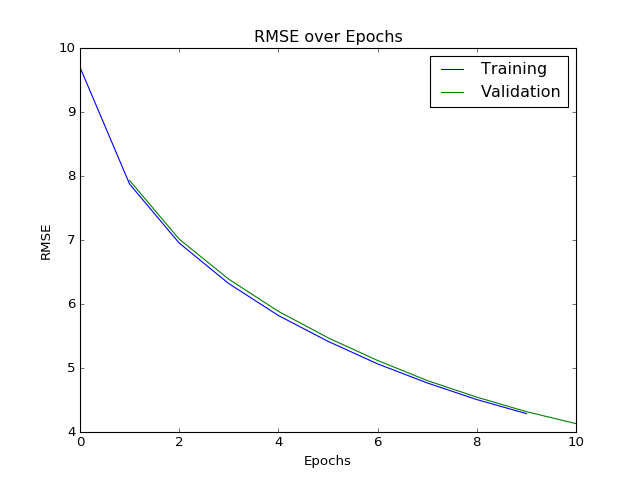

In [10]:
%matplotlib notebook
recommender = RecommenderSystem(n_triplets=1000000, num_factors_k=45, file_name=file_name, zip_location=zip_location)

print('Number of triplets:', recommender.n_triplets)
print('Size of preprocessed matrix:', recommender.R.shape)
print('Amount of non-zero entries:', len(recommender.R.nonzero()[0]))
print()

learning_rate = 1e-4    # learning rate
max_epochs = 10         # maximum epochs to run for
regular = 0.5           # regularization parameter
batch_size = None       # batch size (None for bulk, 1 for SGD)

print('Using learning rate = {}, max epochs = {}, regularization = {}, batch size = {}'.format(learning_rate, max_epochs, regular, batch_size))
error, duration, epochs, train_e, val_e = recommender.batch_SGD(learning_rate, max_epochs, regular, batch_size)
print('Final validation RMS error of:', error)
print('An iteration takes on average: {:f}sec'.format(duration / epochs))
print('Iterations needed until convergence:', epochs)
print('RMS Error on the test set:', recommender.evaluate_test())

plt.plot(range(epochs), train_e, label='Training')
plt.plot(range(1, epochs+1), val_e, label='Validation')
plt.title('RMSE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

## Stochastic Gradient Descent

Using single samples instead of the whole dataset allows for a significantly higher 
learning rate without divergence. Although runtime is still fairly slow for an epoch,
we already achieved remarkably good performance after 3 epochs.

Convergence is also a lot faster than the standard approach, although at 33 epochs
for the included sample, it still takes quite long.

Initialize P and Q with random method
Number of triplets: 1500000
Size of preprocessed matrix: (46074, 31080)
Amount of non-zero entries: 1252143

Using learning rate = 0.004, max epochs = 100, regularization = 0.5, batch size = 1
Running SGD with batch size 1
Converged!
Final validation RMS error of: 1.01783450231
An iteration takes on average: 164.380392sec
Iterations needed until convergence: 33
RMS Error on the test set: 0.973298293774


<IPython.core.display.Javascript object>


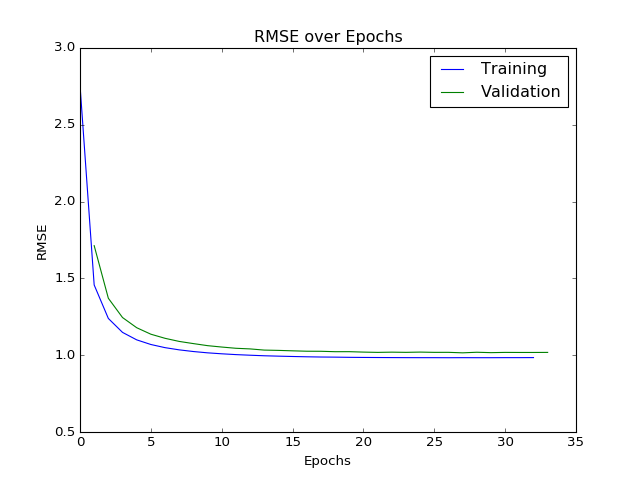

In [5]:
%matplotlib notebook
recommender = RecommenderSystem(n_triplets=1500000, num_factors_k=30, file_name=file_name, zip_location=zip_location)

print('Number of triplets:', recommender.n_triplets)
print('Size of preprocessed matrix:', recommender.R.shape)
print('Amount of non-zero entries:', len(recommender.R.nonzero()[0]))
print()

learning_rate = 4e-3    # learning rate
max_epochs = 100        # maximum epochs to run for
regular = 0.5           # regularization parameter
batch_size = 1          # batch size (None for bulk, 1 for SGD)

print('Using learning rate = {}, max epochs = {}, regularization = {}, batch size = {}'.format(learning_rate, max_epochs, regular, batch_size))
error, duration, epochs, train_e, val_e = recommender.batch_SGD(learning_rate, max_epochs, regular, batch_size)
print('Final validation RMS error of:', error)
print('An iteration takes on average: {:f}sec'.format(duration / epochs))
print('Iterations needed until convergence:', epochs)
print('RMS Error on the test set:', recommender.evaluate_test())

plt.plot(range(epochs), train_e, label='Training')
plt.plot(range(1, epochs+1), val_e, label='Validation')
plt.title('RMSE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

## Batch SGD

Somewhat inexplicably, batch SGD results in more or less the same results as bulk gradient
descent, with very slow learning rates required to prevent divergence, and thus over
100 iterations until convergence (depending somewhat on data size). 

Maximum data set is still very much limited by computation time.

Overall, this approach does not perform better than Alternating Optimization for us. Only
the stochastic gradient descent with individual samples can rival AO in our case.

Experiments showed that memory was a limiting factor when attempting to run the entire dataset
of 48 million triplets, however oddly enough it was limiting for the file read, not for the
actual gradient descent.

Initialize P and Q with random method
Number of triplets: 1000000
Size of preprocessed matrix: (34231, 20343)
Amount of non-zero entries: 783438

Using learning rate = 0.0001, max epochs = 10, regularization = 0.5, batch size = 300000
Running SGD with batch size 300000
Reached epoch limit before converging!
Final validation RMS error of: 3.62449659987
An iteration takes on average: 65.276860sec
Iterations needed until convergence: 10
RMS Error on the test set: 3.42853497909


<IPython.core.display.Javascript object>


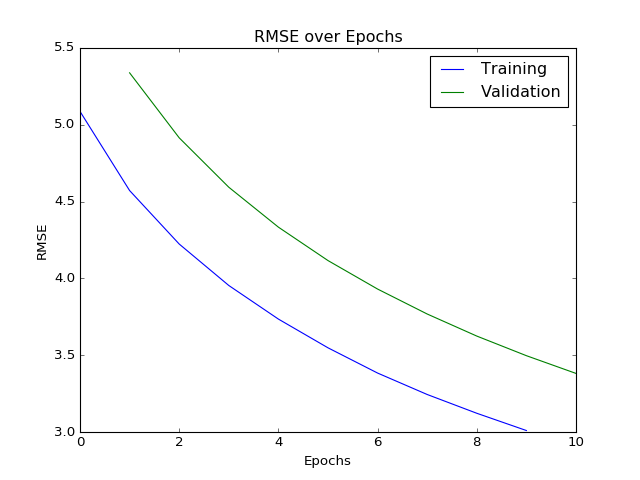

In [9]:
%matplotlib notebook
recommender = RecommenderSystem(n_triplets=1000000, num_factors_k=30, file_name=file_name, zip_location=zip_location)

print('Number of triplets:', recommender.n_triplets)
print('Size of preprocessed matrix:', recommender.R.shape)
print('Amount of non-zero entries:', len(recommender.R.nonzero()[0]))
print()

learning_rate = 1e-4    # learning rate
max_epochs = 10         # maximum epochs to run for
regular = 0.5           # regularization parameter
batch_size = 300000     # batch size (None for bulk, 1 for SGD)

print('Using learning rate = {}, max epochs = {}, regularization = {}, batch size = {}'.format(learning_rate, max_epochs, regular, batch_size))
error, duration, epochs, train_e, val_e = recommender.batch_SGD(learning_rate, max_epochs, regular, batch_size)
print('Final validation RMS error of:', error)
print('An iteration takes on average: {:f}sec'.format(duration / epochs))
print('Iterations needed until convergence:', epochs)
print('RMS Error on the test set:', recommender.evaluate_test())
                                                                
plt.plot(range(epochs), train_e, label='Training')
plt.plot(range(1, epochs+1), val_e, label='Validation')
plt.title('RMSE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()